#### Notebook setup

In [1]:
import time
import warnings
import os, sys
from copy import deepcopy
from types import SimpleNamespace
from pprint import pprint as print

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm.auto import tqdm, trange

from vendor.multirotor.multirotor.helpers import control_allocation_matrix, DataLog
from vendor.multirotor.multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams, BatteryParams
from vendor.multirotor.multirotor.controller import (
    PosController, VelController,
    AttController, RateController,
    AltController, AltRateController,
    Controller
)
from vendor.multirotor.multirotor.simulation import Multirotor, Propeller, Motor, Battery
from vendor.multirotor.multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from vendor.multirotor.multirotor.env import SpeedsMultirotorEnv, DynamicsMultirotorEnv
from vendor.multirotor.multirotor.trajectories import Trajectory
from vendor.multirotor.multirotor.visualize import plot_datalog
from vendor.multirotor.multirotor.optimize import optimize, DEFAULTS, run_sim, apply_params

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent

In [2]:
# Tarot T18 params
bp = BatteryParams(max_voltage=22.2)
mp = MotorParams(
    moment_of_inertia=5e-5,
    resistance=0.27,
    # resistance=0.081,
    k_emf=0.0265,
    # k_motor=0.0932,
    speed_voltage_scaling= 0.0347,
    max_current=38.
)
pp = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    # motor=None,
    motor=mp
    
)
vp = VehicleParams(
    propellers=[pp] * 8,
    battery=bp,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.375 * np.pi,
    distances=np.ones(8) * 0.635,
    clockwise=[-1,1,-1,1,-1,1,-1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(dt=0.01, g=9.81)

In [3]:
# # Plot motor speeds as a function of time and input voltage signal
# plt.figure(figsize=(8,8))
# motor = Motor(mp, sp)
# for vsignal in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
#     speeds = []
#     motor.reset()
#     speed = vsignal / mp.speed_voltage_scaling
#     for i in range(200):
#         speeds.append(motor.step(speed))
#     plt.plot(speeds, label='%d rad/s' % speed)
# plt.legend(ncol=2)
# plt.ylabel('Speed rad/s')
# plt.xlabel('Time /ms')
# # plt.ylim(530,550)

### Parameters

In [4]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [5]:
best_agent = PIDAgent()
best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000}
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
references = []
errors = []
speeds = []
env = env_selector.get_env("sliding", best_params, [(0,0),(0,0),(0,0)], square_wpts, start_alt=30, has_turbulence=False)
params = env.base_env.ctrl.get_params()

In [6]:
params

{'ctrl_p': {'k_p': array([0.38, 0.38]),
  'k_i': array([0., 0.]),
  'k_d': array([0.31666667, 0.31666667]),
  'max_err_i': array(1.),
  'max_velocity': 15,
  'max_acceleration': 3.0,
  'max_jerk': 100.0,
  'square_root_scaling': False,
  'leashing': False},
 'ctrl_v': {'k_p': array([0.07, 0.07]),
  'k_i': array([0.0005, 0.0005]),
  'k_d': array([0.005, 0.005]),
  'max_err_i': array([3.]),
  'max_tilt': 0.39269908169872414},
 'ctrl_a': {'k_p': array([3., 3., 3.]),
  'k_i': array([0., 0., 0.]),
  'k_d': array([0.5, 0.5, 0.5]),
  'max_err_i': array(1.),
  'max_acceleration': 0.2,
  'max_jerk': 100.0,
  'square_root_scaling': False},
 'ctrl_r': {'k_p': array([5., 5., 5.]),
  'k_i': array([0., 0., 0.]),
  'k_d': array([0., 0., 0.]),
  'max_err_i': array(0.5),
  'max_acceleration': array([8.3891751 , 8.3891751 , 0.35866418])},
 'ctrl_z': {'k_p': array([0.4], dtype=float32),
  'k_i': array([0.], dtype=float32),
  'k_d': array([0.], dtype=float32),
  'max_err_i': array(1., dtype=float32),
  'm

### PID Controller

In [7]:
ctrl = env.base_env.ctrl

In [8]:
optimal_params = ctrl.get_params()

#### Attitude Rate Controller

In [9]:
# optimal_params['ctrl_a']['k_p'] = np.array([5, 5, 5]) - 3
# optimal_params['ctrl_a']['k_i'] = np.array([0,0,0])
# optimal_params['ctrl_a']['k_d'] = np.array([0,0,0])

In [10]:
# optimal_params['ctrl_r']['k_p'] = np.array([10, 10, 10])
# optimal_params['ctrl_r']['k_i'] = np.array([0,0,0])
# optimal_params['ctrl_r']['k_d'] = np.array([0,0,0])

In [37]:
# optimal_params['ctrl_a']['k_p'] = np.array([3, 3, 3]) #+ 4
optimal_params['ctrl_a']['k_p'] = np.array([5, 5, 5]) - 1.5
optimal_params['ctrl_a']['k_i'] = np.array([0,0,0])
# optimal_params['ctrl_a']['k_d'] = np.array([0,0,0]) + 0.5
optimal_params['ctrl_a']['k_d'] = np.array([0,0,0]) 
# optimal_params['ctrl_a']['k_d'] = np.array([0,0,0])


In [38]:
# optimal_params['ctrl_r']['k_p'] = np.array([5, 5, 5]) #+ 7
optimal_params['ctrl_r']['k_p'] = np.array([8, 8, 8]) + 2
optimal_params['ctrl_r']['k_i'] = np.array([0,0,0])
optimal_params['ctrl_r']['k_d'] = np.array([0,0,0]) 

In [39]:
ctrl.set_params(**optimal_params)

RateController(k_p=array([10., 10., 10.]), k_i=array([0., 0., 0.]), k_d=array([0., 0., 0.]), max_err_i=array(0.5), vehicle=<multirotor.simulation.Multirotor object at 0x7f1827043d30>, max_acceleration=100)
AttController(k_p=array([3.5, 3.5, 3.5]), k_i=array([0., 0., 0.]), k_d=array([0., 0., 0.]), max_err_i=array(1.), vehicle=<multirotor.simulation.Multirotor object at 0x7f1827043d30>, max_acceleration=0.2, max_jerk=100.0, square_root_scaling=False)


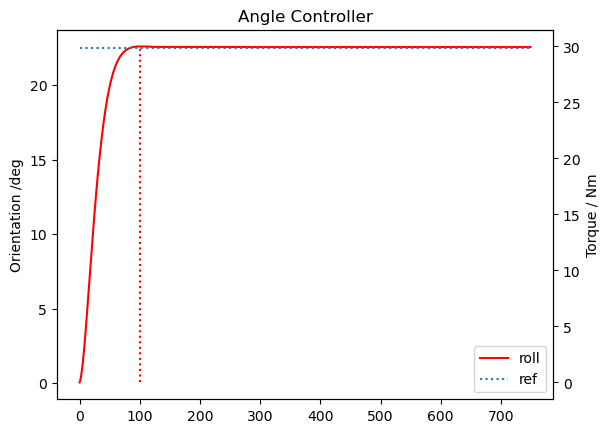

In [41]:
m = Multirotor(vp, sp)
m.speeds = np.array([363.52]*8, dtype=np.float32)
fz = m.weight
rat = ctrl.ctrl_r
print(rat)
att = ctrl.ctrl_a
print(att)
log = DataLog(vehicle=m, controller=ctrl, other_vars=('err',))
for i in range(750):
    # if i > 100:
    #     ref = np.asarray([0.3926991, 0, 0])
    # else:  
    #     ref = np.asarray([0, 0, 0])
        
    ref = np.asarray([0.3926991, 0, 0])
    
    rate = att.step(ref, m.orientation, m.simulation.dt)
    torque = rat.step(rate, m.euler_rate, m.simulation.dt)
    # action = np.clip(torque, a_min=-0.1, a_max=0.1)
    action = torque
    m.step_dynamics(np.asarray([0, 0, 0, *action]))
    log.log(err=rate[0])
    log._actions[-1] = action
log.done_logging()

plt.plot(log.roll * 180 / np.pi, c='r', label='roll')
plt.plot([ref[0] * 180 / np.pi]*750, ls=':', label='ref')

plt.ylabel('Orientation /deg')
plt.legend()
plt.twinx()
plt.ylabel('Torque / Nm')
plt.title("Angle Controller")
plt.vlines(x=[100], ymin=0, ymax=30, color='red', linestyle=':')

# plt.xlim(10, 150)


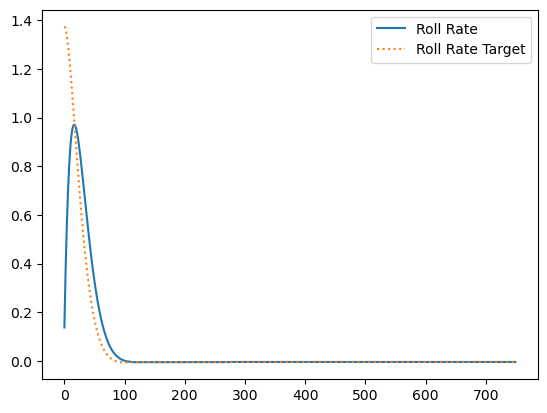

In [42]:
plt.plot(log.angular_rate[:,0], label='Roll Rate')
plt.plot(log.target.rate[:,0], label='Roll Rate Target', linestyle=':')
plt.legend()

### Velocity Controller

In [50]:
print(ctrl.ctrl_v)

VelController(k_p=array([0.07, 0.07]), k_i=array([0.0005, 0.0005]), k_d=array([0.005, 0.005]), max_err_i=array([3.]), vehicle=<multirotor.simulation.Multirotor object at 0x7fd3d878b040>, max_tilt=0.39269908169872414)


In [58]:
# optimal_params['ctrl_v']['k_p'] = np.array([0.01, 0.01]) * 11
# optimal_params['ctrl_v']['k_p'] = np.array([0.01, 0.01]) * 5
optimal_params['ctrl_v']['k_p'] = np.array([1, 1])



# optimal_params['ctrl_v']['k_i'] = np.array([0.01,0.01]) * 5 / 10
optimal_params['ctrl_v']['k_i'] = np.array([0.01,0.01]) 
# optimal_params['ctrl_v']['k_i'] = np.array([0.01,0.01]) * 11 / 100

optimal_params['ctrl_v']['max_err_i'] = np.array([3])

# optimal_params['ctrl_v']['k_d'] = np.array([0.01,0.01]) * 11 / 10
optimal_params['ctrl_v']['k_d'] = np.array([0.01,0.01]) * 0
# optimal_params['ctrl_v']['k_d'] = np.array([0.01,0.01]) * 10


optimal_params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)


ctrl.set_params(**optimal_params)

VelController(k_p=array([0.5, 0.5]), k_i=array([0.01, 0.01]), k_d=array([0., 0.]), max_err_i=array([3.]), vehicle=<multirotor.simulation.Multirotor object at 0x7f1827043d30>, max_tilt=0.39269908169872414)


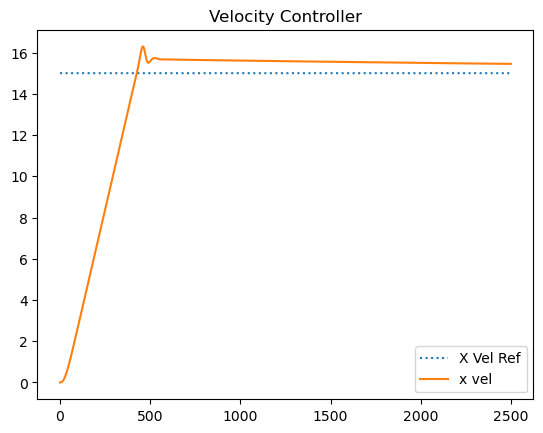

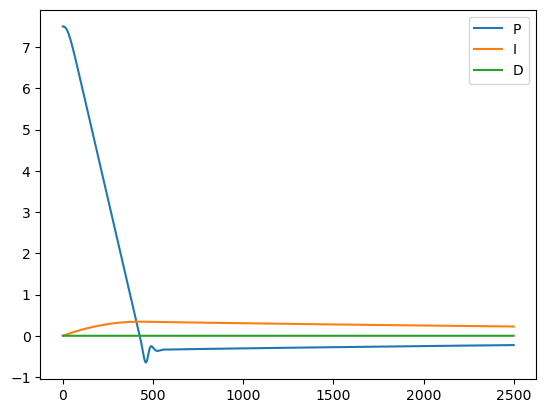

In [59]:
m = Multirotor(vp, sp)
vel = ctrl.ctrl_v
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
vel.reset()
print(vel)
log = DataLog(vehicle=m, other_vars=('thrust',))
x_range = 2500

ref_angles = []
ref_rates = []
errs = []
torques = []

for i in range(x_range):
    ref = np.asarray([15., 0])
    angles = vel.step(ref, m.velocity[:2], dt=0.01)[::-1]
    ref_angles.append(angles)
    rate = att.step(np.asarray([*angles, 0]), m.orientation, dt=0.01)
    ref_rates.append(rate)
    action = rat.step(rate, m.euler_rate, dt=0.01)
    # action = np.clip(action, a_min=-0.1, a_max=0.1)
    # action = np.clip(action, a_min=-0.0091, a_max=0.0091)
    
    # m.step_dynamics(np.asarray([0, 0, 0, 0, 0, 0]))
    torques.append(action)
    m.step_dynamics(np.asarray([0, 0, m.weight, *action]))
    errors = [vel.err_p[0], vel.err_i[0], vel.err_d[0]]
    errs.append(errors)
    
    log.log(thrust=action)
log.done_logging()

plt.plot([ref[0]]*x_range, ls=':', label='X Vel Ref')
plt.plot(log.velocity[:,0], label='x vel')
plt.legend()
plt.title("Velocity Controller")
plt.show()

errs = np.array(errs)
plt.plot(errs[:,0], label='P')
plt.plot(errs[:,1], label='I')
plt.plot(errs[:,2], label='D')
# plt.ylim(0,1)
plt.legend()

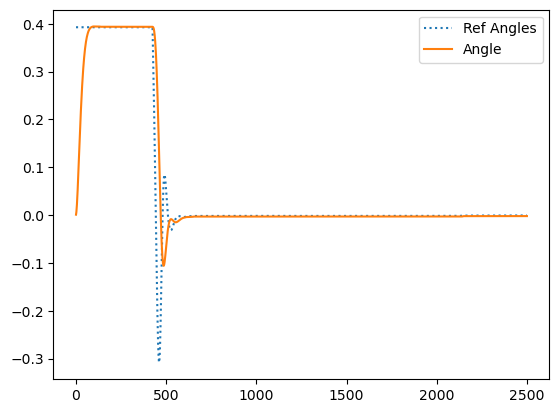

In [60]:
plt.plot(np.array(ref_angles)[:,1], label='Ref Angles', linestyle=':')
plt.plot(log.orientation[:,1], label='Angle')
plt.legend()

#### Altitude Controller

In [131]:
# optimal_params['ctrl_z']['k_p'] = np.array([0.1])
# optimal_params['ctrl_z']['k_i'] = np.array([0.05])
# optimal_params['ctrl_z']['k_d'] = np.array([0.01])
optimal_params['ctrl_z']['max_velocity'] = np.array([1.5])

z_params = optimal_params['ctrl_z']

In [56]:
# optimal_params['ctrl_vz']['k_p'] = np.array([5])
# optimal_params['ctrl_vz']['k_i'] = np.array([0])
# optimal_params['ctrl_vz']['k_d'] = np.array([0])

In [57]:
# ctrl.set_params(**optimal_params)

AltController(k_p=array([0.4], dtype=float32), k_i=array([0.], dtype=float32), k_d=array([0.], dtype=float32), max_err_i=array(1., dtype=float32), vehicle=<multirotor.simulation.Multirotor object at 0x7f1827043d30>, max_velocity=1.5)
AltRateController(k_p=25, k_i=array([0]), k_d=array([0]), max_err_i=array(1), vehicle=<multirotor.simulation.Multirotor object at 0x7f1827043d30>)


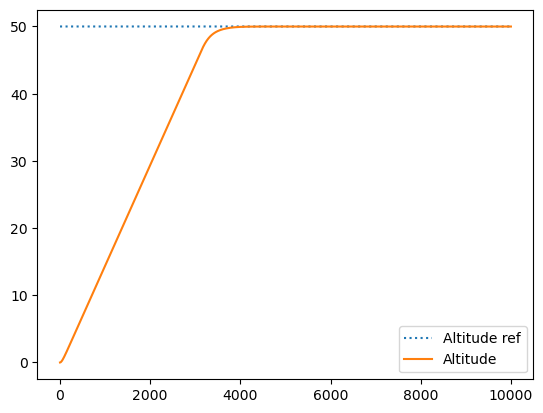

In [133]:
m = Multirotor(vp, sp)
alt = ctrl.ctrl_z
alt.set_params(**z_params)
alt.max_velocity = 1.5
print(alt)
alt_rate = ctrl.ctrl_vz
print(alt_rate)
actions = []
actions_unc = []
log = DataLog(vehicle=m, other_vars=('thrust',))
for i in range(10000):
    ref = np.asarray([50.])
    rate = alt.step(ref, m.position[2:], dt=0.1)
    action = alt_rate.step(rate, m.inertial_velocity[2:], dt=0.1)
    actions_unc.append(action)
    
    # action = np.clip(action, a_min=-2*m.weight, a_max=2*m.weight)
    actions.append(action)
    m.step_dynamics(np.asarray([0, 0, action[0], 0, 0, 0]))
    log.log(thrust=action)
log.done_logging()

plt.plot([ref]*10000, ls=':', label='Altitude ref')
plt.plot(log.z, label='Altitude')
plt.legend()

#### Position Controller

In [61]:
optimal_params['ctrl_p']['k_p'] = np.array([0.38, 0.38])
# optimal_params['ctrl_a']['k_p'] = np.array([2.68,0, 0])
# optimal_params['ctrl_p']['k_i'] = np.array([0.38,0.38]) / 50
optimal_params['ctrl_p']['k_i'] = np.array([0.38,0.38]) * 0

optimal_params['ctrl_p']['k_d'] = np.array([0.38,0.38]) * 0
ctrl.set_params(**optimal_params)

PosController(k_p=array([0.38, 0.38]), k_i=array([0., 0.]), k_d=array([0., 0.]), max_err_i=array(1.), vehicle=<multirotor.simulation.Multirotor object at 0x7f1827043d30>, max_velocity=15, max_acceleration=3.0, max_jerk=100.0, square_root_scaling=False, leashing=False)
VelController(k_p=array([0.5, 0.5]), k_i=array([0.01, 0.01]), k_d=array([0., 0.]), max_err_i=array([3.]), vehicle=<multirotor.simulation.Multirotor object at 0x7f1827043d30>, max_tilt=0.39269908169872414)


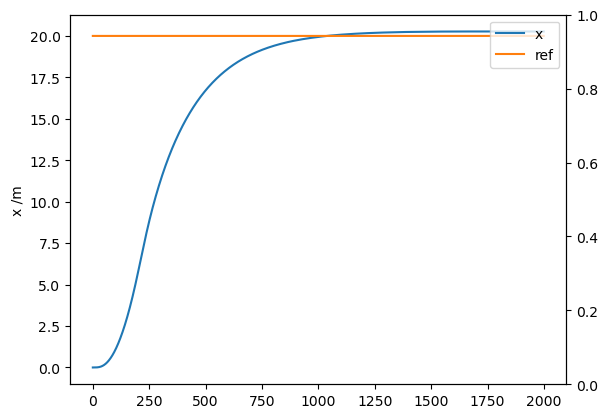

In [64]:
m = Multirotor(vp, sp)
pos = ctrl.ctrl_p
print(pos)
vel = ctrl.ctrl_v
vel.reset()
print(vel)
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
log = DataLog(vehicle=m, other_vars=('err', 'torques'))
for i in range(2000):
    ref = np.asarray([20.,0.])

    velocity = pos.step(ref, m.position[:2], dt=0.01)
    if np.linalg.norm(velocity) > 15:
        velocity = (velocity / np.linalg.norm(velocity)) * 15
    angles = vel.step(velocity, m.velocity[:2], dt=0.01)[::-1]
    rate = att.step(np.asarray([*angles, 0]), m.orientation, dt=0.01)
    action = rat.step(rate, m.euler_rate, dt=0.01)
    # action = np.clip(action, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, m.weight, *action]))
    log.log(err=pos.err[0], torques=action)
log.done_logging()

plt.plot(log.x, label='x')
plt.plot([ref[0]]*2000, label='ref')
plt.ylabel('x /m')
l = plt.gca().lines
plt.twinx()
plt.legend(handles=plt.gca().lines+l)
plt.show()

In [134]:
import pickle
with open('./params/manual_pid.pkl', 'wb') as file:
    pickle.dump(ctrl.get_params(), file)

## Defining Trajectories

## Test Experiment

In [62]:
# # optimal_params['ctrl_v']['k_p'] = np.array([0.01, 0.01]) * 11
# optimal_params['ctrl_v']['k_p'] = np.array([0.01, 0.01]) * 7


# optimal_params['ctrl_v']['k_i'] = np.array([0.01,0.01]) * 5 / 100
# # optimal_params['ctrl_v']['k_i'] = np.array([0.01,0.01]) * 11 / 100

# optimal_params['ctrl_v']['max_err_i'] = np.array([3])

# optimal_params['ctrl_v']['k_d'] = np.array([0.01,0.01]) * 5 / 10
# # optimal_params['ctrl_v']['k_d'] = np.array([0.01,0.01]) * 0


# optimal_params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)


# ctrl.set_params(**optimal_params)
# import pickle
# with open('./params/manual_pid.pkl', 'wb') as file:
#     pickle.dump(ctrl.get_params(), file)

In [122]:
best_agent = PIDAgent()
best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000}
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
references = []
errors = []
speeds = []

def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    env = env_selector.get_env("sliding", params, wind_ranges, nasa_wp, start_alt=30, has_turbulence=False)
    params = env.base_env.ctrl.get_params()
    params['ctrl_p']['max_velocity'] = 15
    params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)
    params['ctrl_v']['k_p'] = np.array([0.1,0.1])
    params['ctrl_v']['k_d'] = np.array([0.01,0.01])
    
    params['ctrl_p']['k_p'] = np.array([0.08, 0.08])
    print(params['ctrl_z'])
    # params['ctrl_v']['k_i'] = params['ctrl_v']['k_i'] * 0
    
    env.base_env.ctrl.set_params(**params)
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        errors.append([env.base_env.ctrl.ctrl_v.err_p, env.base_env.ctrl.ctrl_v.err_i])
        speeds.append([env.base_env.vehicle.speeds])

    log.done_logging()
    return log, info, np.array(errors), np.array(speeds)

log, info, errors, speeds = run_trajectory(env_selector, [(0,0), (0,0), (0,0)], best_agent, best_params)

{'k_d': array([0.01, 0.01]),
 'k_i': array([0.01, 0.01]),
 'k_p': array([0.1, 0.1]),
 'max_err_i': array([3.]),
 'max_tilt': 0.39269908169872414}
[0. 0. 0. 0. 0. 0. 0. 0.]
[367.81628 360.22986 367.95358 360.70584 368.47537 360.98334 368.33826
 360.50775]
[367.1776  362.84763 366.74133 362.52737 366.72998 362.83142 367.1663
 363.1514 ]
[355.5316  372.61972 355.45517 372.8202  355.82874 373.12357 355.9051
 372.92322]
[367.8203  363.17307 368.04715 363.02692 367.6162  362.55533 367.38913
 362.70166]
[361.14066 368.06622 361.153   368.01086 361.06088 367.93842 361.04855
 367.99374]
[367.91782 360.56003 368.269   360.54697 367.8997  360.02643 367.54813
 360.03955]
[368.84375 360.24966 368.88104 360.3375  368.96506 360.37134 368.9278
 360.2835 ]


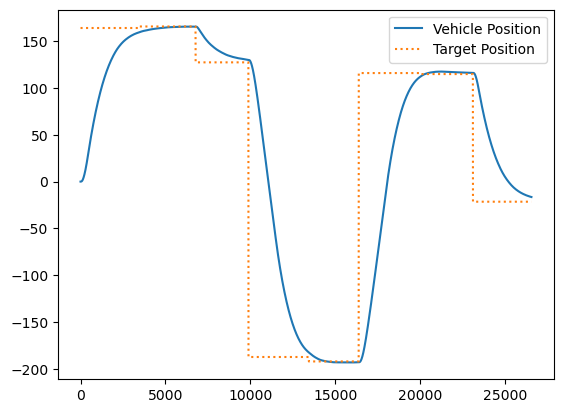

In [123]:
plt.plot(log.position[:,0], label='Vehicle Position')
plt.plot(log.target.position[:,0], linestyle=':', label='Target Position')
plt.legend()

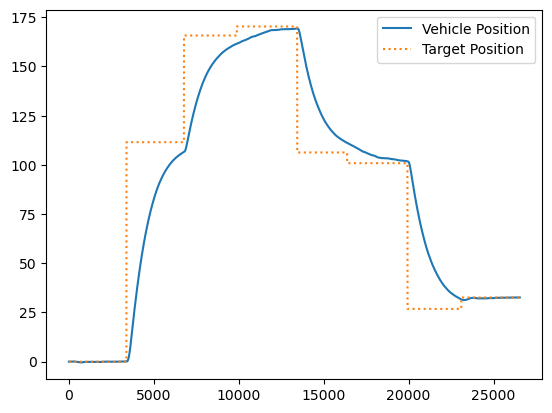

In [124]:
plt.plot(log.position[:,1], label='Vehicle Position')
plt.plot(log.target.position[:,1], linestyle=':', label='Target Position')
plt.legend()

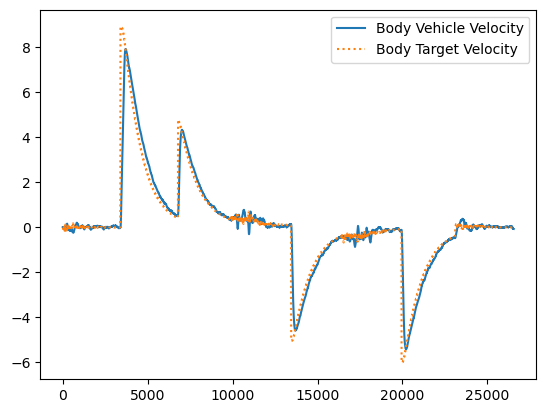

In [125]:
plt.plot(log.velocity[:,1], label='Body Vehicle Velocity')
plt.plot(log.target.velocity[:,1], linestyle=':', label='Body Target Velocity')
plt.legend()

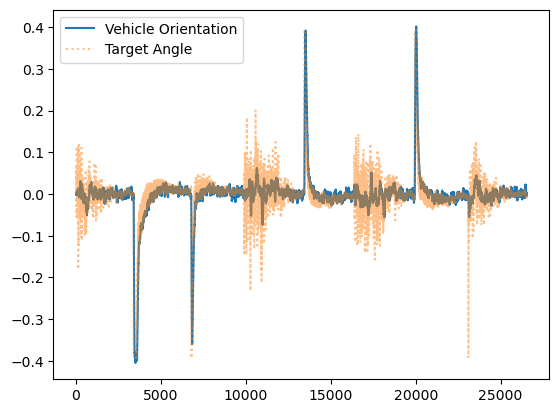

In [126]:
plt.plot(log.orientation[:,0], label='Vehicle Orientation')
plt.plot(log.target.orientation[:,0], linestyle=':', label='Target Angle', alpha=0.5)
plt.legend()

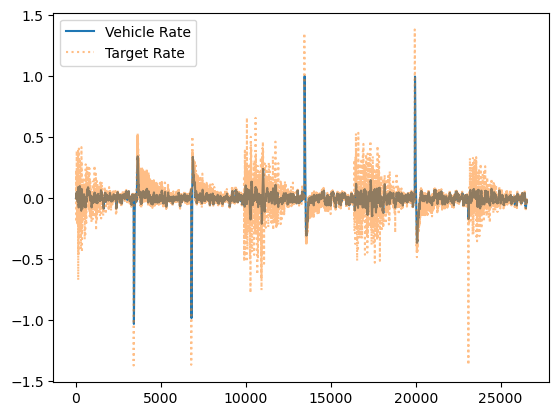

In [127]:
plt.plot(log.angular_rate[:,0], label='Vehicle Rate')
plt.plot(log.target.rate[:,0], linestyle=':', label='Target Rate', alpha=0.5)
plt.legend()

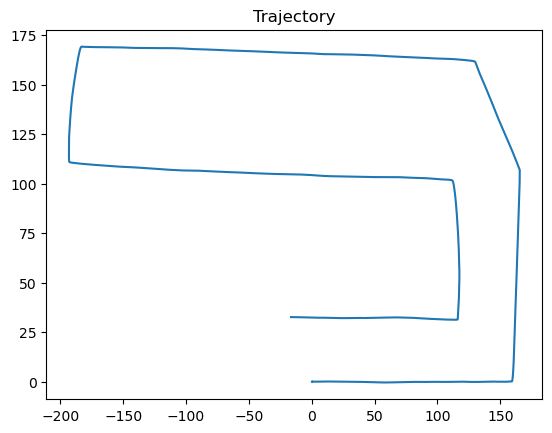

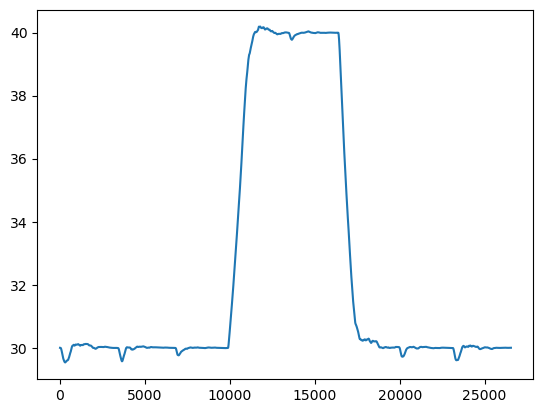

In [128]:
plt.plot(log.x, log.y)
plt.title("Trajectory")
plt.show()

plt.plot(log.z)